In [349]:
from psycopg2 import connect
import pandas.io.sql as pandasql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, time
import matplotlib as mpl
import copy
import matplotlib.dates as mdates

CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\qchen\Documents\qchen.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [451]:
#date_key = 20170915
#date_key_list = "(20170911, 20170912, 20170913)"

travel_times_sql = '''
-- takes the arrivaltime_fromstop for each trip_id and identifies the bin(s) it falls into
drop table if exists trip_bin15;
create temp table trip_bin15 as(
select bt_id, bt_id_name, trip_id, 
(timestamp without time zone 'epoch' + (floor((extract('epoch' from arrivaltime_fromstop) / {1} )) * {1}) * INTERVAL '1 second') bin15
from ttc.avl a
inner join ttc.ttc_bt_lookup i on (currentstop_pointstop_key = f_id AND lead_pointstop_key = t_id)
where date_key = {0}
group by bt_id, bt_id_name, trip_id, bin15
order by bt_id, bt_id_name, bin15
);

-- gives the sum of a trip_id's travel times for the bluetooth segment
drop table if exists tt_sum;
create temp table tt_sum as(
select bt_id, bt_id_name, trip_id, sum(extract(epoch from (arrivaltime_tostop - arrivaltime_fromstop))) travel_time
from ttc.avl a
inner join ttc.ttc_bt_lookup i on (currentstop_pointstop_key = f_id AND lead_pointstop_key = t_id)
where date_key = {0}
group by bt_id, bt_id_name, trip_id
order by bt_id, bt_id_name, trip_id
);

-- grabs earliest bin for each trip_id to associate the travel times to
drop table if exists tween;
create temp table tween as(
select t.bt_id, t.bt_id_name, t.trip_id, travel_time, min(bin15) timebin
from tt_sum t
inner join trip_bin15 b using (trip_id)
where travel_time > 0
group by t.bt_id, t.bt_id_name, t.trip_id, travel_time
order by t.bt_id, t.bt_id_name, timebin, t.trip_id
);

-- averages the travel times that fall within the same bin
select bt_id, bt_id_name, round(avg(travel_time)::numeric, 0)::integer avg_tt, timebin
from tween
where travel_time > 0
group by bt_id, bt_id_name, timebin
order by bt_id, bt_id_name, timebin
'''

#travel_times = pandasql.read_sql(travel_times_sql.format(date_key), con)


trip_sql = '''
-- grabs earliest bin for each trip_id to associate the travel times to
select t.bt_id, t.trip_id, travel_time::integer, min(bin15) timebin
from tt_sum t
inner join trip_bin15 b using (trip_id)
where travel_time > 0
group by t.bt_id, t.bt_id_name, t.trip_id, travel_time
order by t.bt_id, t.bt_id_name, timebin, t.trip_id
'''

#trip_tt = pandasql.read_sql(trip_sql.format(date_key), con)

In [452]:
def plot_ttavg(dk, minint):
    date_key = dk
    interval = minint * 60
    
    travel_times = pandasql.read_sql(travel_times_sql.format(date_key, interval), con)
    trip_tt = pandasql.read_sql(trip_sql.format(date_key), con)
    
    bt_list = travel_times.bt_id.unique()
    #bt_list = [27, 28, 57, 58]
    fig, ax = plt.subplots(len(bt_list), 1, sharex = False, sharey = True, figsize = (16, 3.5*len(bt_list)))
    print('Travel times by Bluetooth segment for ' + str(date_key) + ' in ' + str(minint) + ' minute intervals')
    
    bx = []
    for i, segment in enumerate(bt_list):
        indiv = trip_tt[trip_tt['bt_id'] == segment]
        avgdf = travel_times[travel_times['bt_id'] == segment]
        bx.append(ax[i].twiny())
        ax[i].plot_date(y = indiv['travel_time'], 
                        x = indiv['timebin'], 
                        xdate = True,
                        fmt = 'o', 
                        color = 'b',
                        alpha = 0.5)
        
        bx[i].plot_date(y = avgdf['avg_tt'],
                        x = avgdf['timebin'],
                        xdate = True,
                        fmt = '-', 
                        color = 'r',
                        alpha = 1.0)
        
        ax[i].xaxis.set_major_locator(mdates.HourLocator(byhour = range(0,24), interval = 1))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        ax[i].set_title(avgdf['bt_id_name'].unique()[0])
        bx[i].get_xaxis().set_visible(False)
        for label in ax[i].get_xmajorticklabels():
            label.set_rotation(30)
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

Actual Travel Times with Trips
Travel times by Bluetooth segment for 20170915 in 15 minute intervals


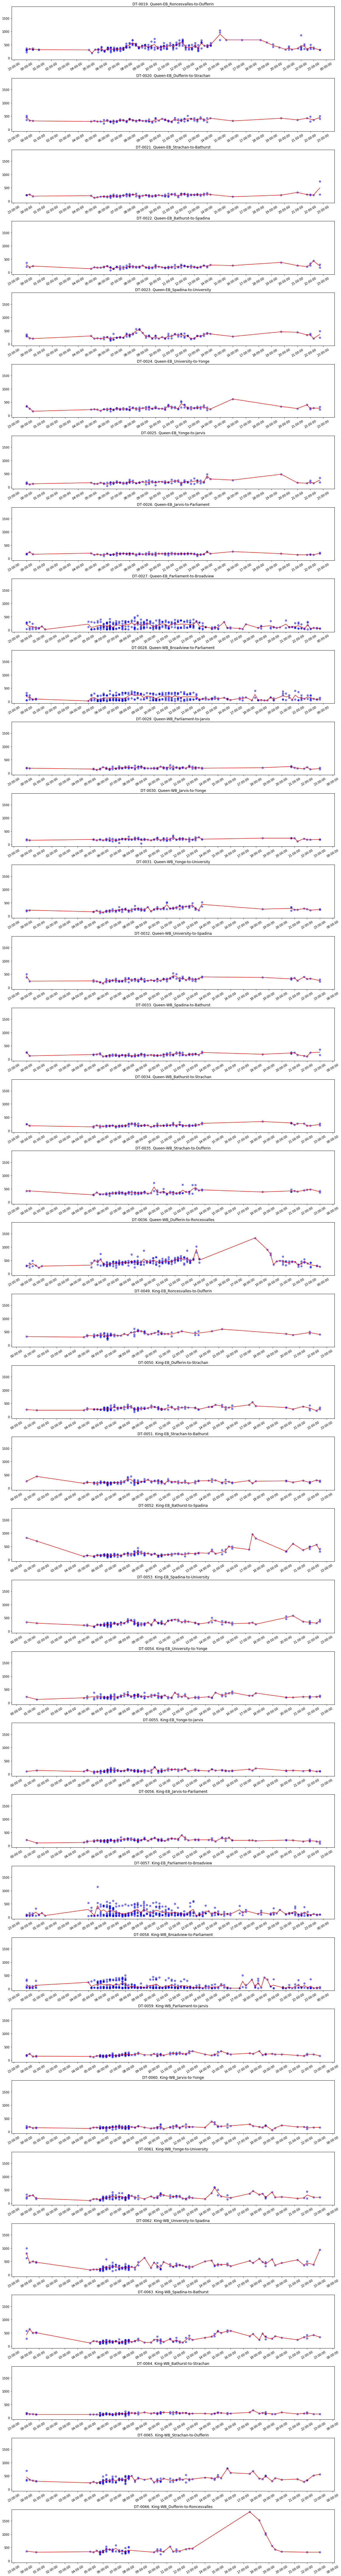

In [454]:
print('Actual Travel Times with Trips')
plot_ttavg(20170915, 15)

Actual Travel Times with Trips
Travel times by Bluetooth segment for 20170915


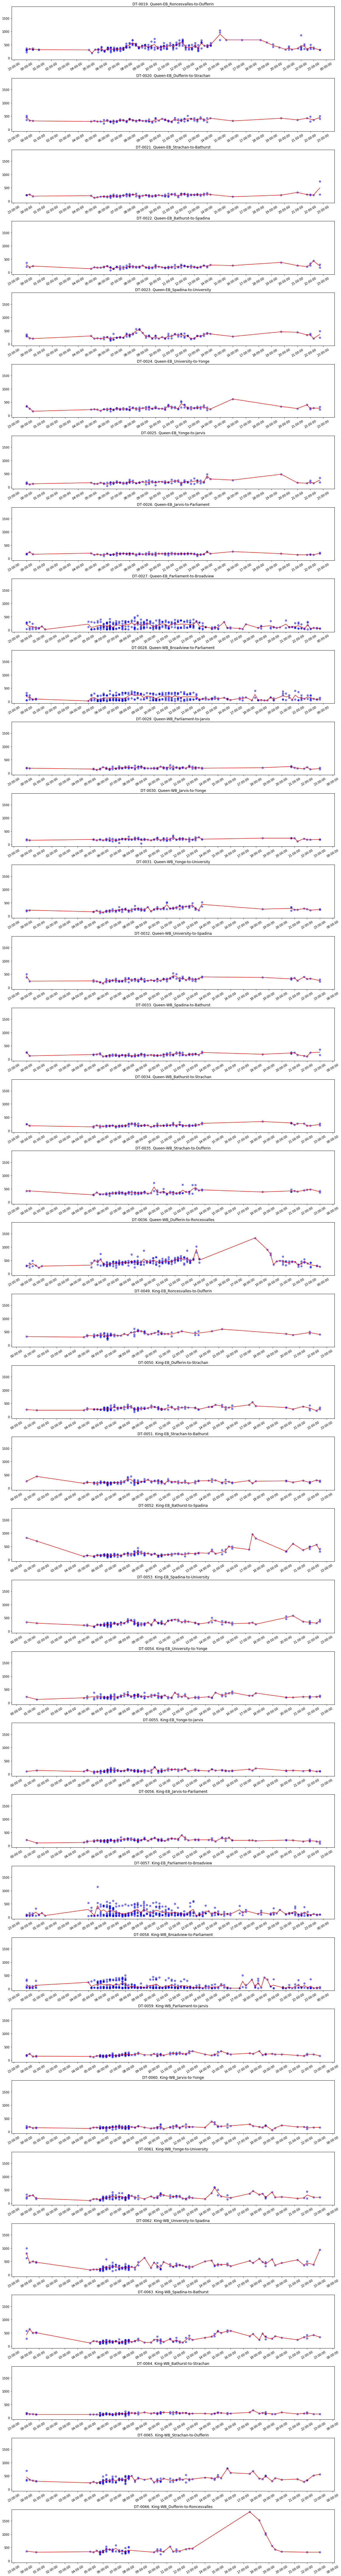

In [438]:
print('Actual Travel Times with Trips')
plot_ttavg(travel_times, trip_tt)

Actual Travel Times with Trips
Travel times by Bluetooth segment for 20170915


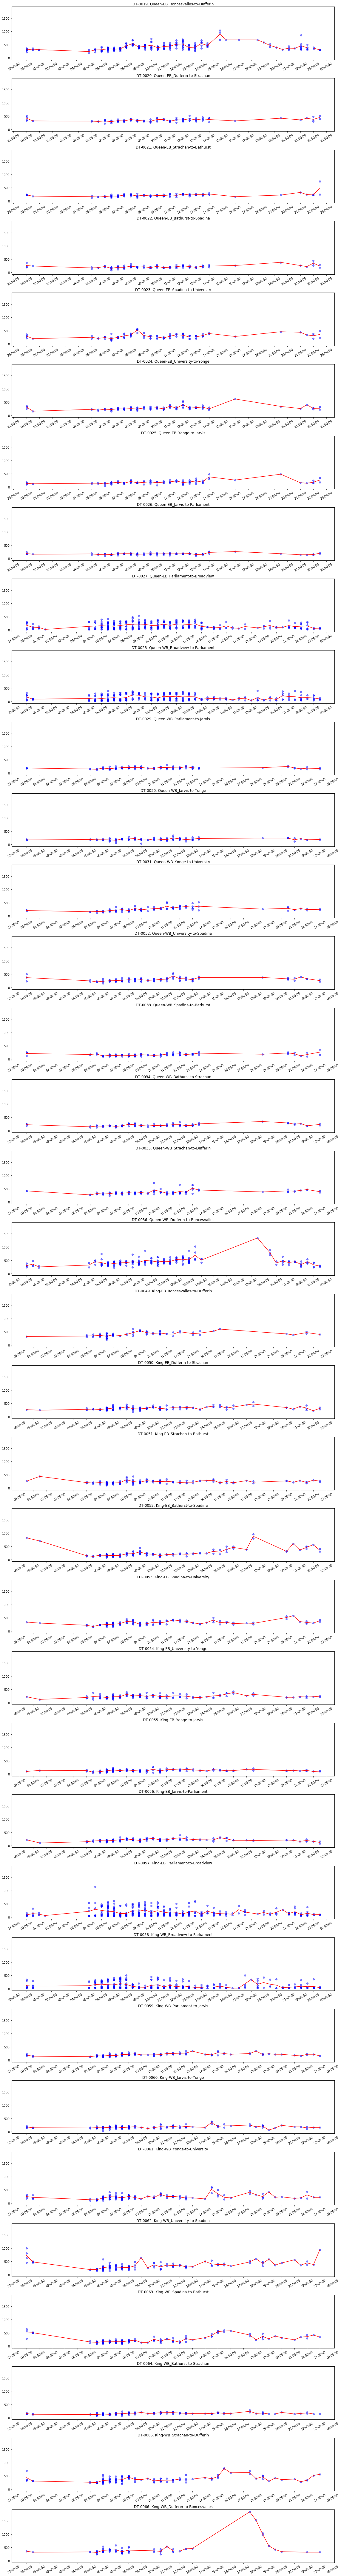

In [435]:
print('Actual Travel Times with Trips')
plot_ttavg(travel_times, trip_tt)